In [2]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from PIL import Image, ImageDraw

from process import map_vgrade, id_to_index, id_to_coordinate, frame_to_ids, frame_to_triplets, triplets_to_matrix, frame_to_sparse_matrix, is_frame_valid, filter_frame, filter_climbs, sort_frame, filtered_df_to_text_file
from visualize import analyze_starting_hold_heights, plot_vgrade_counts, plot_hold_counts, print_unique_climbs_count, count_unique_words, draw_colored_circles_on_image, frame_to_imagecoords, frame_to_image
from markov import Markov, predict_valid_sequence
import embeddings as emb
from embeddings import hold_directions2, hold_directions, hold_magnitudes
import torch
from torch.utils.data import Dataset

ModuleNotFoundError: No module named 'process'

### Creating SQL Database Connection and Converting tables to dfs ###

In [ ]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [ ]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

# print("Number of climbs:", filtered_df.shape[0])

### Some Graphs

In [ ]:
# plot_vgrade_counts(filtered_df)
# plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [ ]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


In [1]:
# frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
# frame_to_image(frame)

NameError: name 'filtered_df' is not defined

### Markov Chain Model

Successfully Trained
Valid Sequence: 1476r15 1487r15 1149r12 1506r15 1235r13 1253r13 1308r13 1327r15 1335r13 1357r14 1371r13 1459r15 1084r15
[(236, 847.0, 5), (362, 805.0, 5), (381, 784, 2), (448, 719.0, 5), (423, 574, 3), (465, 532, 3), (633, 406, 3), (717, 364, 5), (339, 322, 3), (549, 280, 4), (423, 238, 3), (240, 976, 5), (262, 955, 5)]


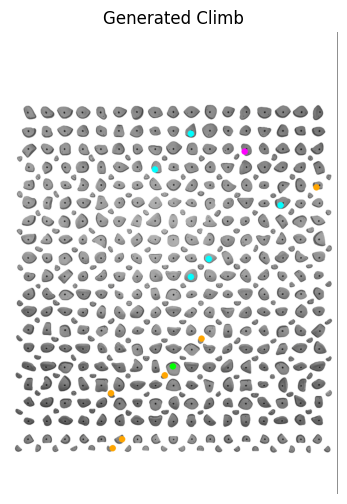

In [8]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1476r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [9]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

### Prepare Data into npz file ###

In [10]:
def get_hold_vector(row, col):
    if not isinstance(row, int):
        raise TypeError(f"Row index must be an integer, got {type(row)} row: {row}")
    if not isinstance(col, int):
        raise TypeError(f"Column index must be an integer, got {type(col)} col: {col}")
    
    if row > 34 or col > 34:
        if row > col:
            raise ValueError(f"Row index {row} exceeds maximum allowed value of 34.")
        else:
            raise ValueError(f"Column index {col} exceeds maximum allowed value of 34.")
    
    if max(hold_directions[34 - row][col]) > 1:
        index = int(hold_directions[34 - row][col][0]) - 1
        hold_direction = hold_directions2[index].tolist()
    else:
        hold_direction = hold_directions[34 - row][col].tolist()
    
    hold_magnitude = hold_magnitudes[34 - row][col][0]
    
    return hold_direction, hold_magnitude

# hold_direction, hold_magnitude = get_hold_vector(row, col)

def unit_vector_to_sin(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    sin_value = np.sin(angle_radians)
    return sin_value

def unit_vector_to_cos(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    cos_value = np.cos(angle_radians)
    return cos_value

def modified_hold_quality(climb_angle, hold_quality):
    if isinstance(climb_angle, torch.Tensor):
        climb_angle_cpu = climb_angle.cpu().numpy()
    else:
        climb_angle_cpu = np.array(climb_angle)
    climb_angle_radians = np.deg2rad(climb_angle_cpu)
    modified_quality = np.cos(climb_angle_radians * hold_quality)
    return modified_quality

def interhold_angle(a, b):
    x1, y1 = a
    x2, y2 = b
    angle_radians = np.arctan2(y2 - y1, x2 - x1)
    return angle_radians

def average_unit_vectors(vectors):
    if len(vectors) == 1:
        return vectors[0]
    elif len(vectors) == 2:
        avg_x = (vectors[0][0] + vectors[1][0]) / 2
        avg_y = (vectors[0][1] + vectors[1][1]) / 2
        norm = np.sqrt(avg_x**2 + avg_y**2)
        return [avg_x / norm, avg_y / norm]
    else:
        raise ValueError("The input should be a list containing one or two unit vectors.")

def id_to_class_id(id):
    if id <=1089: # 0-16
        class_id = id - 1073 
    elif id <=1395: # 17-322
        class_id = id - 1090 + 17
    elif id <= 1464: # 323-340
        class_id = id - 1447 + 323
    elif id <= 1599: # 341-475
        class_id = id - 1465 + 341
    return class_id

def class_id_to_id(class_id):
    if class_id <= 16:  # 0-16
        id = class_id + 1073
    elif class_id <= 322:  # 17-322
        id = class_id + 1090 - 17
    elif class_id <= 340:  # 323-340
        id = class_id + 1447 - 323
    elif class_id <= 475:  # 341-475
        id = class_id + 1465 - 341 
    return id

def ids_to_hold_val_class_id(hold_class_id, val_class_id):
    hold_val_class_id = (hold_class_id) * 4 + val_class_id
    return hold_val_class_id

def hold_val_class_id_to_ids(hold_val_class_id):
    val_class_id = hold_val_class_id % 4
    hold_class_id = int((hold_val_class_id - val_class_id) /4)
    return hold_class_id, val_class_id

def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_class_id, hold_val_class_id, hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=40000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = np.copy(matrix)
    standardized_matrix[:, [0, 1, 5, 6]] = (matrix[:, [0, 1, 5, 6]] - global_means[[0, 1, 5, 6]]) / global_stds[[0, 1, 5, 6]]
    return standardized_matrix


def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def hold_to_tuple(hold_class_id, val,):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = class_id_to_id(int(hold_class_id))
    x, y = id_to_coordinate(hold_id)

    val_class_id = val-2
    hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    
    feature_tuple = (y, x, val_class_id, hold_class_id, hold_val_class_id, hold_angle, hold_quality)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple

[ 1.72713299e+01  1.70057850e+01  1.63265319e+00  2.24947278e+02
  9.01421766e+02 -3.75248771e-03  5.92365072e-01]


### RNN Model ###

Train and Val Datasets Created
Balanced Train and Val Datasets Created
Train Dataset Size: 16970
Validation Dataset Size: 14540
Test Dataset Size: 4000
Train and Val Loaders Created
Epoch [1/10], Train Loss: 4.8629, Train Accuracy: 0.0635, Val Loss: 4.5419, Val Accuracy: 0.0761
Epoch [2/10], Train Loss: 4.4501, Train Accuracy: 0.0663, Val Loss: 4.2450, Val Accuracy: 0.0764
Epoch [3/10], Train Loss: 3.9551, Train Accuracy: 0.1054, Val Loss: 3.8156, Val Accuracy: 0.1621
Epoch [4/10], Train Loss: 3.4509, Train Accuracy: 0.1793, Val Loss: 3.5317, Val Accuracy: 0.1897
Epoch [5/10], Train Loss: 3.1220, Train Accuracy: 0.2404, Val Loss: 3.3005, Val Accuracy: 0.2388
Epoch [6/10], Train Loss: 2.8608, Train Accuracy: 0.2912, Val Loss: 3.0234, Val Accuracy: 0.2730
Epoch [7/10], Train Loss: 2.6497, Train Accuracy: 0.3480, Val Loss: 2.9551, Val Accuracy: 0.3006
Epoch [8/10], Train Loss: 2.4219, Train Accuracy: 0.4256, Val Loss: 2.7564, Val Accuracy: 0.4281
Epoch [9/10], Train Loss: 2.2222, Train Ac

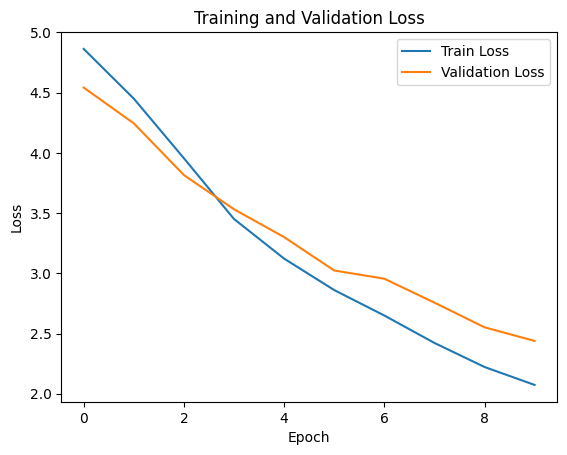

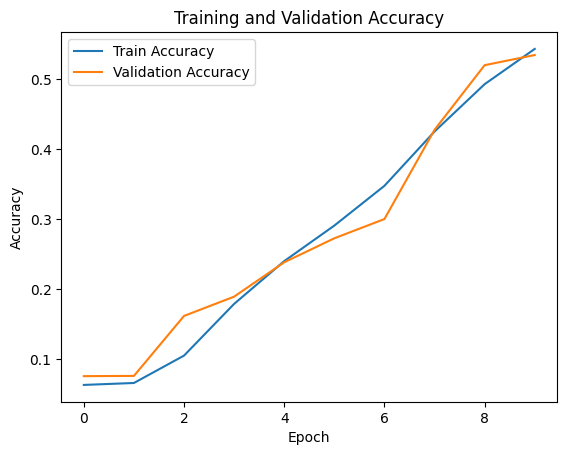

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.parametrizations as weight_norm
import torch.nn.init as init
from collections import Counter
import random

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        climb_name = list(self.data.keys())[idx]
        climb_matrix = self.data[climb_name]
        return climb_matrix, climb_matrix[:, 4].astype(int)

class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize LSTM weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Task-specific layer for hold_val_class prediction
        self.fc_hold_val_class = nn.Linear(hidden_size, 1904)  # Define the linear layer first
        
        # Initialize FC layer weights
        init.xavier_uniform_(self.fc_hold_val_class.weight)
        init.constant_(self.fc_hold_val_class.bias, 0)
        
        # Apply weight normalization using torch.nn.utils.parametrizations.weight_norm
        self.fc_hold_val_class = weight_norm.weight_norm(self.fc_hold_val_class, name='weight', dim=None)

    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        hold_val_class_pred = self.fc_hold_val_class(out)
        
        return hold_val_class_pred, hn, cn

# Define collate function for DataLoader to handle variable-length sequences
def collate_fn(batch):
    sequences = [torch.tensor(climb_matrix, dtype=torch.float32) for climb_matrix, _ in batch]
    lengths = torch.tensor([len(climb_matrix) for climb_matrix, _ in batch])

    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths

# Calculate class frequencies
def calculate_class_frequencies(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, class_ids = dataset[i]
        class_counts.update(class_ids)
    return class_counts

# Create a balanced dataset by undersampling and oversampling
def create_balanced_dataset(dataset, target_class_freq=200):
    class_counts = calculate_class_frequencies(dataset)
    indices_by_class = {class_id: [] for class_id in class_counts}

    for idx in range(len(dataset)):
        _, class_ids = dataset[idx]
        for class_id in class_ids:
            indices_by_class[class_id].append(idx)

    balanced_indices = []

    for class_id, indices in indices_by_class.items():
        if len(indices) > target_class_freq:
            balanced_indices.extend(random.sample(indices, target_class_freq))
        else:
            balanced_indices.extend(indices)
            balanced_indices.extend(random.choices(indices, k=target_class_freq - len(indices)))

    return Subset(dataset, balanced_indices)

# Load your dataset
dataset = ClimbDataset('standardized_climb_matrices.npz')

# Calculate split sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10% for test
remaining_size = total_size - test_size
train_size = int(0.7 * total_size)  # 70% of total for training (which is 70/90 of remaining)
val_size = remaining_size - train_size  # The remaining 20% of total for validation

# Split dataset into train, validation, and test sets
train_val_dataset, test_dataset = random_split(dataset, [remaining_size, test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
print("Train and Val Datasets Created")

# Create balanced datasets for train and validation
train_dataset = create_balanced_dataset(train_dataset, target_class_freq=10)
val_dataset = create_balanced_dataset(val_dataset, target_class_freq=10)
print("Balanced Train and Val Datasets Created")

# Print sizes of the datasets
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders for balanced datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Train and Val Loaders Created")

model = RNN().to(device)

# Define loss functions
criterion_hold_val_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    # Iterate over data
    for padded_sequences, lengths in train_loader:
        padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
        lengths = lengths.to(device)

        optimizer.zero_grad()  # Reset gradients for the new batch

        # Forward pass
        hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)
        
        # Compute hold_val_class loss
        next_tuple_hold_val_class = padded_sequences[torch.arange(padded_sequences.size(0)), lengths.cpu().long() - 1, 4].long()  # Extract target hold_val_class
        loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, next_tuple_hold_val_class)

        # Total loss
        batch_loss = loss_hold_val_class
        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
        
        # Calculate training accuracy
        correct_train_preds += (torch.argmax(hold_val_class_pred, dim=1) == next_tuple_hold_val_class).sum().item()
        total_train_preds += next_tuple_hold_val_class.size(0)
    
    # Compute average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for padded_sequences, lengths in val_loader:
            padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
            lengths = lengths.to(device)

            # Forward pass
            hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)

            # Compute hold_val_class loss
            next_tuple_hold_val_class = padded_sequences[torch.arange(padded_sequences.size(0)), lengths.cpu().long() - 1, 4].long()  # Extract target hold_val_class
            loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, next_tuple_hold_val_class)

            # Total loss
            batch_loss = loss_hold_val_class
            running_val_loss += batch_loss.item()

            # Calculate validation accuracy
            correct_val_preds += (torch.argmax(hold_val_class_pred, dim=1) == next_tuple_hold_val_class).sum().item()
            total_val_preds += next_tuple_hold_val_class.size(0)
    
    # Compute average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Class index: 1258, Frequency: 1353
Hold id and Val: 1387, 2
Class index: 645, Frequency: 1017
Hold id and Val: 1234, 1
Class index: 1295, Frequency: 973
Hold id and Val: 1447, 3
Class index: 1274, Frequency: 962
Hold id and Val: 1391, 2
Class index: 989, Frequency: 957
Hold id and Val: 1320, 1
Class index: 917, Frequency: 957
Hold id and Val: 1302, 1
Class index: 1250, Frequency: 939
Hold id and Val: 1385, 2
Class index: 1363, Frequency: 915
Hold id and Val: 1464, 3
Class index: 1121, Frequency: 909
Hold id and Val: 1353, 1
Class index: 1331, Frequency: 877
Hold id and Val: 1456, 3
Class index: 1266, Frequency: 865
Hold id and Val: 1389, 2
Class index: 1242, Frequency: 849
Hold id and Val: 1383, 2
Class index: 841, Frequency: 832
Hold id and Val: 1283, 1
Class index: 925, Frequency: 832
Hold id and Val: 1304, 1
Class index: 857, Frequency: 824
Hold id and Val: 1287, 1
Class index: 1069, Frequency: 823
Hold id and Val: 1340, 1
Class index: 1315, Frequency: 803
Hold id and Val: 1452, 3
C

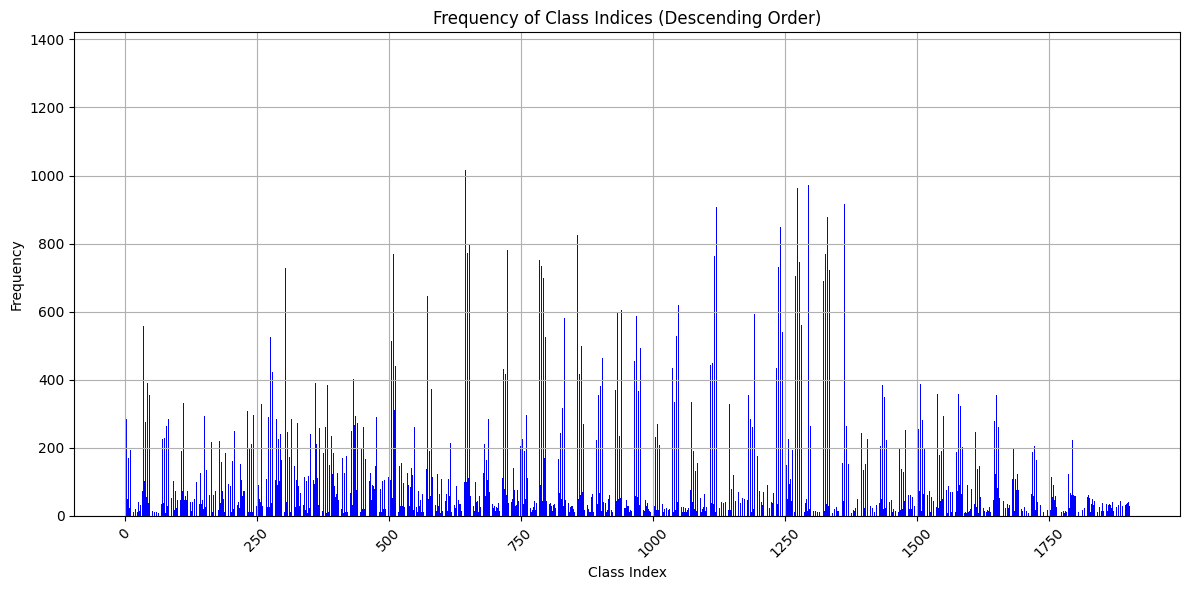

Total sum of frequencies: 217942
Total number of holds in the dataset: 1495085
There is a discrepancy in the hold count.


In [15]:
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader

# Example function to calculate class frequencies excluding padding
def calculate_class_frequencies(dataset, padding_value=-1):
    class_counts = Counter()
    
    # Calculate class frequencies
    for padded_sequences, lengths in DataLoader(dataset, batch_size=1, collate_fn=collate_fn):
        hold_val_classes = padded_sequences[:, :, 4].long().cpu().numpy().flatten()
        valid_indices = hold_val_classes != padding_value  # Exclude padding values
        class_counts.update(hold_val_classes[valid_indices])
    
    return class_counts

# Example dataset and calculation
class_counts = calculate_class_frequencies(train_dataset)

# Sort class indices by frequency in descending order
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
class_indices = list(sorted_class_counts.keys())
frequencies = list(sorted_class_counts.values())

# Print each class index with its frequency
for idx, freq in zip(class_indices, frequencies):
    hold_class_id, val_id = hold_val_class_id_to_ids(idx)
    print(f"Class index: {idx}, Frequency: {freq}\nHold id and Val: {class_id_to_id(hold_class_id)}, {val_id}")

# Plotting the frequencies
plt.figure(figsize=(12, 6))
plt.bar(class_indices, frequencies, color='blue')
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.title('Frequency of Class Indices (Descending Order)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate the total sum of frequencies
total_frequency = sum(class_counts.values())
padding_value = 0
# Verify total number of holds in the dataset, excluding padding
total_instances = sum(((batch[0]- 0) != padding_value).sum().item() for batch in DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn))

# Print the total sum of frequencies and total number of holds
print(f"Total sum of frequencies: {total_frequency}")
print(f"Total number of holds in the dataset: {total_instances}")

# Verify if all holds are counted
if total_frequency == total_instances:
    print("All holds are correctly counted.")
else:
    print("There is a discrepancy in the hold count.")


In [ ]:
total_instances = sum(len(batch[0]) for batch in DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn))

In [ ]:
print(len(dataset))

40000


In [ ]:
import matplotlib.pyplot as plt

# Assuming weight_tensor is your tensor containing class weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(weight_tensor)), weight_tensor.cpu().numpy())
plt.xlabel('Class Index')
plt.ylabel('Weight')
plt.title('Class Weights')
plt.show()

NameError: name 'weight_tensor' is not defined

<Figure size 1000x600 with 0 Axes>

### Generate RNN Climb ###

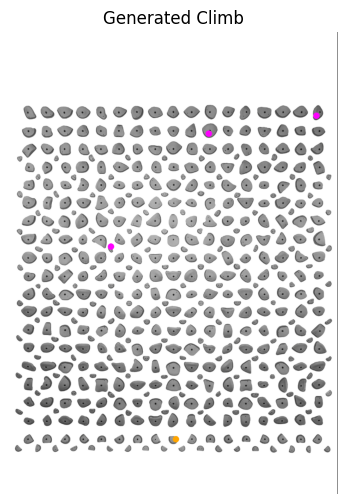

In [18]:
def climb_to_tupleslist(row):
    frames = row['frames']

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        
        feature_tuple = (y, x, val- 2 , hold_class_id, hold_val_class_id, hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples



import random

def generate_climb(model, starting_hold_id, starting_val, num_holds):
    model.eval()
    
    # Initialize the starting tuple and convert to tensor
    starting_class_id = id_to_class_id(starting_hold_id)
    current_tuple = torch.tensor([hold_to_tuple(starting_class_id, starting_val)], dtype=torch.float).unsqueeze(0).to(device)

    generated_hold_ids = [starting_hold_id]
    generated_vals = [starting_val]

    # Initialize hidden states
    h0, c0 = None, None
    
    with torch.no_grad():
        for _ in range(num_holds - 1):
            lengths = torch.tensor([current_tuple.size(1)], dtype=torch.int64).to(device)

            hold_val_class_logits, h0, c0 = model(current_tuple, lengths, h0, c0)
            
            # Apply softmax to convert logits to probabilities
            hold_val_class_prob = F.softmax(hold_val_class_logits, dim=1)
            
            # hold_val_class_prob_cpu = hold_val_class_prob.squeeze().cpu().numpy()
            # plt.figure(figsize=(10, 6))
            # plt.bar(range(len(hold_val_class_prob_cpu)), hold_val_class_prob_cpu)
            # plt.xlabel('Hold Value Class ID')
            # plt.ylabel('Probability')
            # plt.title(f'Hold Value Class Probabilities at Step {_ + 1}')
            # plt.show()
            hold_val_class_id = torch.argmax(hold_val_class_prob, dim=1).item()
            # hold_val_top_indices = torch.topk(hold_val_class_prob, k=5, dim=1)[1].squeeze().tolist()
            # hold_val_class_id = random.choice(hold_val_top_indices)
            hold_class_id, val_class = hold_val_class_id_to_ids(hold_val_class_id)
            generated_hold_ids.append(class_id_to_id(hold_class_id))
            generated_vals.append(val_class)

            # Prepare the next input
            next_tuple = hold_to_tuple(hold_class_id, val_class)
            next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
            
            # Concatenate next_tensor along the sequence dimension (dim=1)
            current_tuple = torch.cat((current_tuple, next_tensor), dim=1)
    
    return generated_hold_ids, generated_vals

def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
    # green, cyan, magenta, orange
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

hold_ids, vals = generate_climb(model, 1081, 3, 12)
climb_to_image(hold_ids, vals)


In [ ]:
print(hold_ids, vals)

[1081, 1395, 1395, 1395, 1395, 1395, 1395, 1395, 1395, 1395, 1395, 1395] [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
# show(filtered_df)
print(torch.cuda.is_available())

True
